In [1]:
## NN Classification Problem
# Data: using make_circles() to generate two circles with different colored dots

from sklearn.datasets import make_circles

nSamples = 1000  # Number of samples
X, y = make_circles(nSamples, noise=0.03, random_state=42)

In [2]:
print(f"First five X features:\n{X[:5]}")
print(f"\nFirst five y labels:\n{y[:5]}")

First five X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First five y labels:
[1 1 1 1 0]


In [3]:
# Putting the data in the dataframe
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Checking the labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

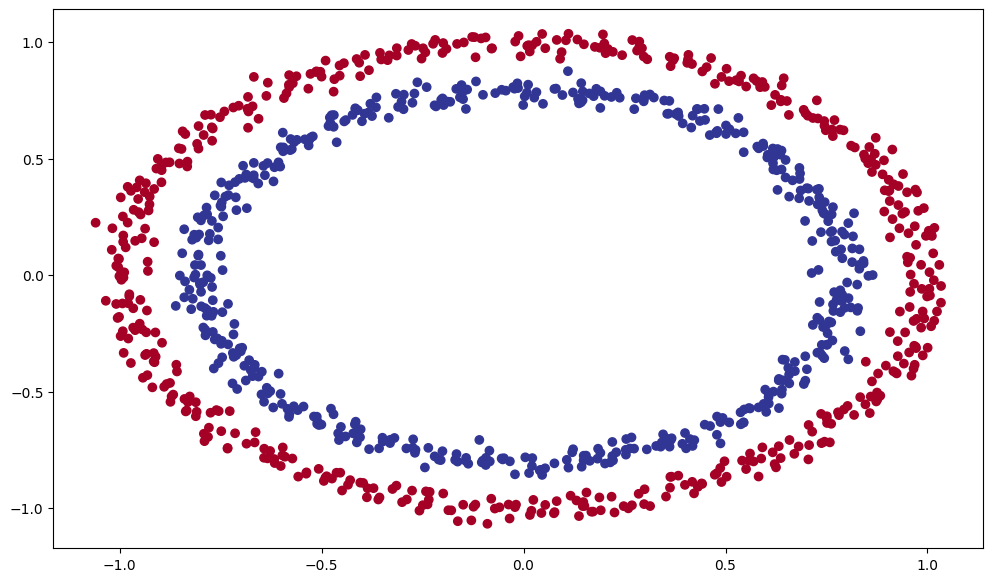

In [5]:
# Visualizing data

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.scatter(x=X[:, 0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu);

## Now there is a problem to solve
Building a model to classify dots in `red(0)` or `blue(1)`

In [6]:
# Checking the array shapes
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# Turning data into tensors

import torch
print(f"Torch Version: {torch.__version__}")

# From numpy to torch tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(f"\nFirst five rows of X:\n{X[:5]}")
print(f"First five rows of y:\n{y[:5]}")

Torch Version: 2.0.1+cu118

First five rows of X:
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First five rows of y:
tensor([1., 1., 1., 1., 0.])


In [8]:
# Test/Train Split
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)
len(XTrain), len(yTrain), len(XTest), len(yTest)

(800, 800, 200, 200)

In [9]:
from torch import nn

# Device agonistic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cpu


In [10]:
# Building model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model0 = CircleModelV0()
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Creating a loss function and optimizer

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)

In [12]:
# Creating an accuracy function

def accuracyFn(yTrue, yPred):
  correct = torch.eq(yTrue, yPred).sum().item()
  acc = (correct / len(yPred)) * 100
  return acc

In [13]:
# Training loop

torch.manual_seed(42)
epochs = 100

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):
  model0.train()

  yLogits = model0(XTrain).squeeze()
  yPred = torch.round(torch.sigmoid(yLogits))

  loss = lossFn(yLogits, yTrain)
  acc = accuracyFn(yTrue = yTrain, yPred = yPred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model0.eval()
  with torch.inference_mode():
    testLogits = model0(XTest).squeeze()
    testPred = torch.round(torch.sigmoid(testLogits))

    testLoss = lossFn(testLogits, yTest)
    testAcc = accuracyFn(yTrue=yTest, yPred=testPred)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.2f} | Test Accuracy: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.72175, Accuracy: 50.00% | Test Loss: 0.72 | Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.70119, Accuracy: 50.00% | Test Loss: 0.70 | Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.69538, Accuracy: 50.00% | Test Loss: 0.70 | Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69369, Accuracy: 50.00% | Test Loss: 0.70 | Test Accuracy: 50.00%
Epoch: 40 | Loss: 0.69320, Accuracy: 53.87% | Test Loss: 0.70 | Test Accuracy: 51.00%
Epoch: 50 | Loss: 0.69305, Accuracy: 52.75% | Test Loss: 0.69 | Test Accuracy: 46.50%
Epoch: 60 | Loss: 0.69300, Accuracy: 51.75% | Test Loss: 0.69 | Test Accuracy: 47.00%
Epoch: 70 | Loss: 0.69299, Accuracy: 51.25% | Test Loss: 0.69 | Test Accuracy: 47.00%
Epoch: 80 | Loss: 0.69298, Accuracy: 51.50% | Test Loss: 0.69 | Test Accuracy: 46.00%
Epoch: 90 | Loss: 0.69298, Accuracy: 51.50% | Test Loss: 0.69 | Test Accuracy: 45.50%


### Plotting Decision Boundary

In [14]:
# Getting helper function

import requests
from pathlib import Path

fileURL = 'https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py'

if Path('helper_functions.py').is_file():
  print("helper_functions.py already exists")

else:
  print("Downloading...")
  request = requests.get(fileURL)

  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

  print("Download complete")

Downloading...
Download complete


In [15]:
from helper_functions import plot_predictions, plot_decision_boundary

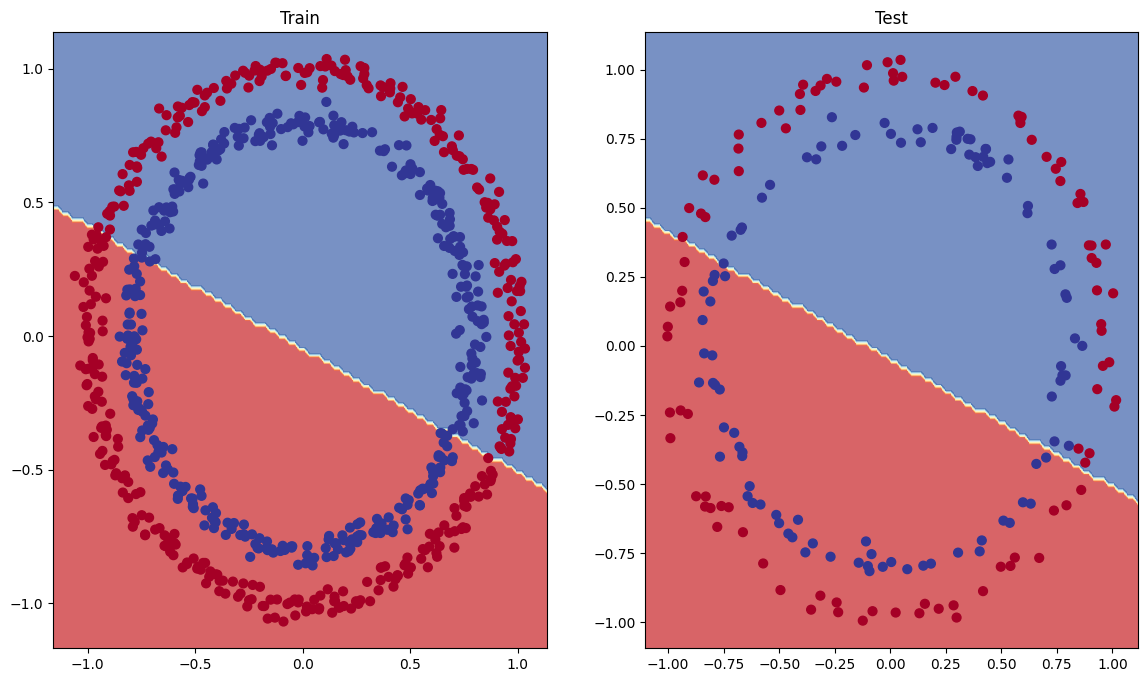

In [16]:
# Plots

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, XTrain, yTrain)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, XTest, yTest)


In [17]:
# Building another model with extra layer

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    return self.layer3(self.layer2(self.layer1(x)))

model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [18]:
# Setting up loss function and optimizer

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.1)

In [19]:
torch.manual_seed(42)

epochs = 1000

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):
  yLogits = model1(XTrain).squeeze()
  yPred = torch.round(torch.sigmoid(yLogits))

  loss = lossFn(yLogits, yTrain)
  acc = accuracyFn(yTrue=yTrain, yPred=yPred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model1.eval()
  with torch.inference_mode():
    testLogits = model1(XTest).squeeze()
    testPred = torch.round(torch.sigmoid(testLogits))

    testLoss = lossFn(testLogits, yTest)
    testAcc = accuracyFn(yTrue=yTest, yPred=testPred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.5f}, Test Accuracy: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test Loss: 0.69261, Test Accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test Loss: 0.69379, Test Accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test Loss: 0.69437, Test Accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test Loss: 0.69458, Test Accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test Loss: 0.69465, Test Accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69467, Test Accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test Loss: 0.69468, Test Accuracy: 46.00%


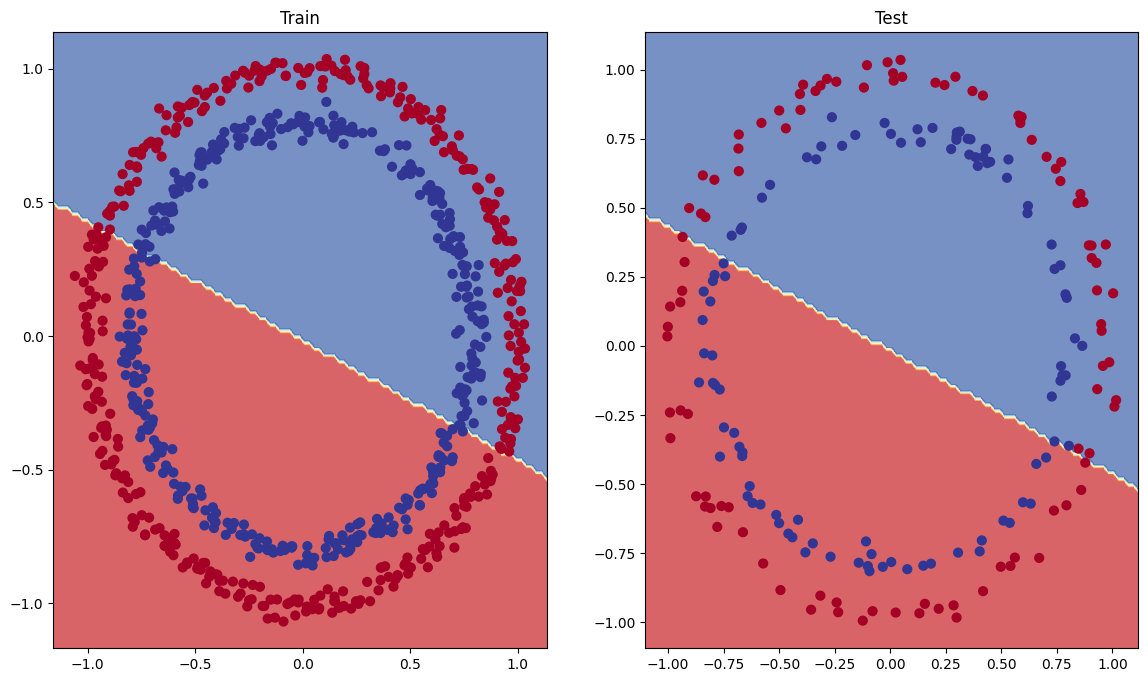

In [20]:
# PLotting decision boundary

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, XTrain, yTrain)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, XTest, yTest)

### Adding Non-linearity to the model

In [21]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10, out_features=10)
    self.layer3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()  # Rectified Linear Unit Activation Function

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model2 = CircleModelV2().to(device)
model2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [22]:
# Loss function and optimizer

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.1)

In [23]:
# Training loop

torch.manual_seed(42)
epochs = 1000

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):
  yLogits = model2(XTrain).squeeze()
  yPred = torch.round(torch.sigmoid(yLogits))

  loss = lossFn(yLogits, yTrain)
  acc = accuracyFn(yTrue=yTrain, yPred=yPred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model2.eval()
  with torch.inference_mode():
    testLogits = model2(XTest).squeeze()
    testPred = torch.round(torch.sigmoid(testLogits))

    testLoss = lossFn(testLogits, yTest)
    testAcc = accuracyFn(yTrue=yTest, yPred=testPred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.5f}, Test Accuracy: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


Adding non-linearity improved the accuracy of the model

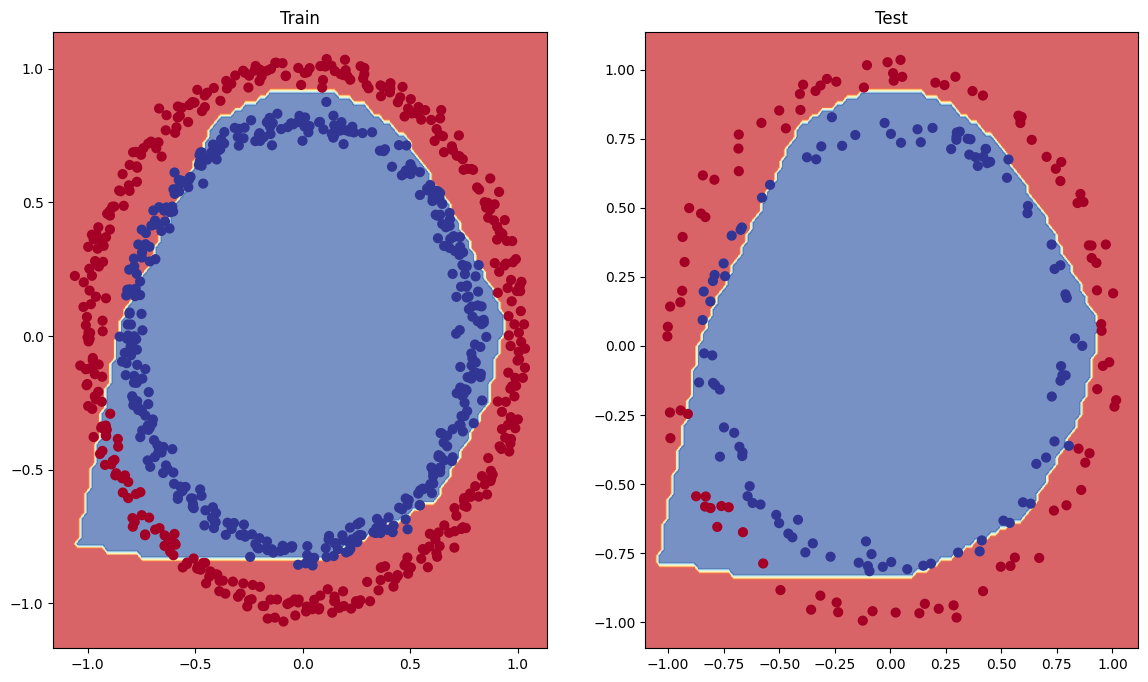

In [24]:
# Plotting decision boundary

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, XTrain, yTrain)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, XTest, yTest)

In [46]:
# Improving model

class CircleModelV3(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=16)
    self.layer2 = nn.Linear(in_features=16, out_features=16)
    self.layer3 = nn.Linear(in_features=16, out_features=16)
    self.layer4 = nn.Linear(in_features=16, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer4(self.relu(self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))))

model3 = CircleModelV3()
model3

CircleModelV3(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=16, bias=True)
  (layer4): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [47]:
# Optimizer and Loss Function

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model3.parameters(), lr=0.1)

In [48]:
# Training loop

torch.manual_seed(42)
epochs = 1500

XTrain, yTrain = XTrain.to(device), yTrain.to(device)
XTest, yTest = XTest.to(device), yTest.to(device)

for epoch in range(epochs):
  yLogits = model3(XTrain).squeeze()
  yPred = torch.round(torch.sigmoid(yLogits))

  loss = lossFn(yLogits, yTrain)
  acc = accuracyFn(yTrue=yTrain, yPred=yPred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model3.eval()
  with torch.inference_mode():
    testLogits = model3(XTest).squeeze()
    testPred = torch.round(torch.sigmoid(testLogits))

    testLoss = lossFn(testPred, yTest)
    testAcc = accuracyFn(yTrue=yTest, yPred=testPred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {testLoss:.5f}, Test Accuracy: {testAcc:.2f}%")

Epoch: 0 | Loss: 0.69512, Accuracy: 50.00% | Test Loss: 0.81326, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69138, Accuracy: 55.62% | Test Loss: 0.69119, Test Accuracy: 60.00%
Epoch: 200 | Loss: 0.69046, Accuracy: 53.50% | Test Loss: 0.69739, Test Accuracy: 59.00%
Epoch: 300 | Loss: 0.68911, Accuracy: 54.12% | Test Loss: 0.69530, Test Accuracy: 60.50%
Epoch: 400 | Loss: 0.68707, Accuracy: 55.00% | Test Loss: 0.69770, Test Accuracy: 60.50%
Epoch: 500 | Loss: 0.68362, Accuracy: 56.00% | Test Loss: 0.69960, Test Accuracy: 60.00%
Epoch: 600 | Loss: 0.67766, Accuracy: 61.88% | Test Loss: 0.68600, Test Accuracy: 62.00%
Epoch: 700 | Loss: 0.66624, Accuracy: 67.75% | Test Loss: 0.64929, Test Accuracy: 68.50%
Epoch: 800 | Loss: 0.64177, Accuracy: 77.75% | Test Loss: 0.63410, Test Accuracy: 72.50%
Epoch: 900 | Loss: 0.57311, Accuracy: 97.00% | Test Loss: 0.51960, Test Accuracy: 96.00%
Epoch: 1000 | Loss: 0.53712, Accuracy: 53.62% | Test Loss: 0.78226, Test Accuracy: 55.00%
Epoch: 1100 | Loss: 0.

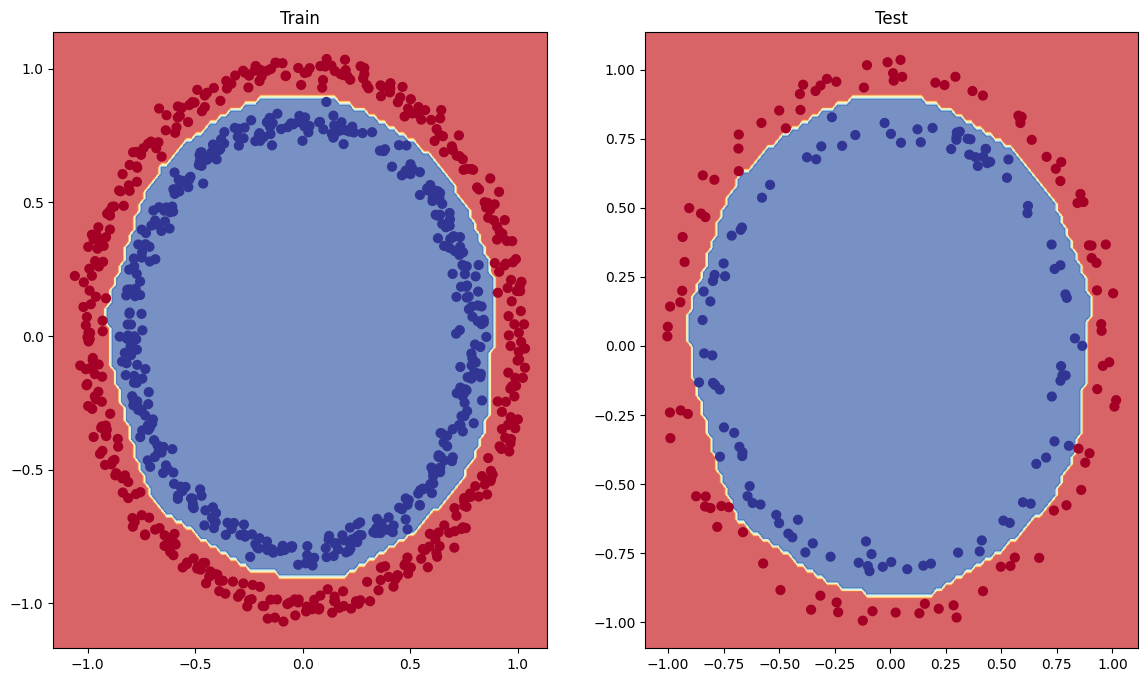

In [49]:
# PLotting decision boundary

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, XTrain, yTrain)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, XTest, yTest)